In [1]:
from analysis import *
import h5py
from astropy.convolution import convolve, Box1DKernel
import sys
import pandas as pd

In [2]:
campaign = 8

all_targets = pd.read_csv("/home/jackeline/Research/k2_pipeline/K2_official_targets/K2Campaign%stargets.csv"%campaign, skipinitialspace=True)
#plt.hist(all_targets.magnitude.)
epic = int(220148939)
mag = all_targets.magnitude[all_targets['EPIC ID'] == epic].values[0]
mag

17.945

In [3]:
if __name__=="__main__":


    channel = 33

    campaign = 8
    mod,submod = get_submod(channel)
    submod-=1 # submods are 0-3 in the hdf5 file

    #hdf5_file = "/Users/rachelbuttry/K2/K2C%s_target_pixels.hdf5"%campaign
    hdf5_file = "/home/jackeline/Research/k2_pipeline/k2_LongTermSystematics/data/pixelmaps/k2pixelmap.hdf5"

    #hdf5_file = "/home/rachel/Research/K2/K2C%s_target_pixels.hdf5"%campaign
    # there are 23117 objects in the campaign 8 hdf5 file
    # there are 3853 cadence points in c8
    cadences = 3853
    time = np.arange(cadences)/48.0

    with h5py.File(hdf5_file, 'r') as f:
        channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod,submod)].keys()))# look at objects in given channel).astype(int)

    # need the kepler magnitudes
    #all_targets = pd.read_csv("./K2_official_targets/K2Campaign%stargets.csv"%campaign, skipinitialspace=True)
    all_targets = pd.read_csv("/home/jackeline/Research/k2_pipeline/K2_official_targets/K2Campaign%stargets.csv"%campaign, skipinitialspace=True)


    # saving lcs to take the median
    arr = []

    with h5py.File(hdf5_file, 'r') as f:
        channel_epics = np.array(list(f['%s/%s/%s'%(campaign, mod, submod)].keys()))# look at objects in given channel).astype(int)
        
        rel_epics = channel_epics[np.isin(channel_epics, all_targets['EPIC ID'][np.logical_and(all_targets['magnitude'] > 16, all_targets['magnitude'] < 20)])]
        #print(len(rel_epics))

        # loop thru the objects
        for epic in rel_epics:
            d = np.array(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)]['data'])
            #print(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)])
            #r = np.array(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)]['row'])
            #c = np.array(f['%s/%s/%s/%s'%(campaign, mod, submod, epic)]['col'])

            lc_hdf5 = np.nansum(np.nansum(d, axis=1), axis=1)

            # handle spurious cadences
            lc = lk.LightCurve(time, flux=lc_hdf5)
            _, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences
            lc_raw = lc.flux

            # interpolate
            cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement
            interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
            # replace spurious cadence values with the interpolated values
            lc_raw[spurious_cad] = interped_vals
            norm = np.std(lc_raw)
            lc_raw -= np.mean(lc_raw)
            lc_raw = lc_raw/norm
            #lc_raw = lc_raw/np.max(np.abs(lc_raw))

            smooth = convolve(lc_raw, Box1DKernel(100), boundary='extend')

            arr.append(lc_raw)



In [4]:
import richardsplot

160


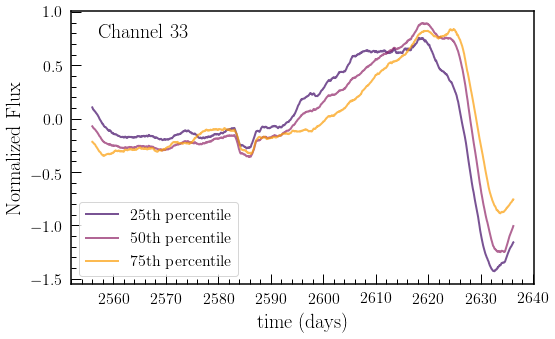

In [9]:
cmap = plt.get_cmap('inferno')
mag_colors = np.zeros((len(cmap.colors),4))
mag_colors[:,3] = 0.7 #this is the alpha parameter
mag_colors[:,:3] = cmap.colors
    
    
print(len(arr))    

fig = plt.figure(figsize=(8,5))

p= 50
flux = np.percentile(np.atleast_2d(np.array(arr)),p, axis=0)
flux_smooth50 = convolve(flux, Box1DKernel(150), boundary='extend')

p= 25
flux25 = np.percentile(np.atleast_2d(np.array(arr)),p, axis=0)
flux_smooth25 = convolve(flux25, Box1DKernel(150), boundary='extend')

p= 75
flux75 = np.percentile(np.atleast_2d(np.array(arr)),p, axis=0)
flux_smooth75 = convolve(flux75, Box1DKernel(150), boundary='extend')

    
#flux = np.array(arr)[i]
    #plt.plot(time, flux, linewidth=4, alpha=0.8, color=mag_colors[i])
plt.plot(time+2556, flux_smooth25-flux_smooth25.mean(), linewidth=2, color=mag_colors[50], label = "25th percentile" )
plt.plot(time+2556, flux_smooth50-flux_smooth50.mean(), linewidth=2, color=mag_colors[100], label = "50th percentile" )
plt.plot(time+2556, flux_smooth75-flux_smooth75.mean(), linewidth=2, color=mag_colors[200], label = "75th percentile" )
plt.text(1+2556,.75,"Channel 33", fontsize = 20 )
plt.ylabel("Normalized Flux", fontsize = 20)
plt.xlabel("time (days)" ,fontsize = 20)

   # plt.plot(time, flux_smooth-flux_smooth.mean(), linewidth=10, color="#e6550d")
    #plt.plot(time, flux_smooth75-flux_smooth75.mean(), linewidth=10, color="purple")

    #plt.ylim(-.4,.4)
#plt.ylim(-1.8,1.8)

#plt.xticks([])
#plt.yticks([])
#plt.xlim(np.min(time), np.max(time))
plt.legend(loc ="lower left", fontsize = 16)
plt.tight_layout()
plt.savefig("/home/jackeline/Research/k2_pipeline/k2_paperFigures/fig6a2.pdf")

In [ ]:
    p= 50
    flux = np.percentile(np.atleast_2d(np.array(arr)),p, axis=0)

160


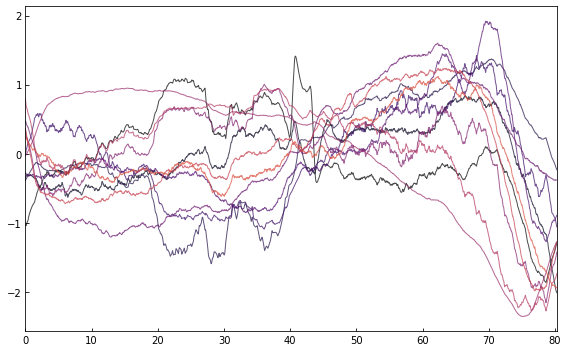

In [17]:
cmap = plt.get_cmap('inferno')
mag_colors = np.zeros((len(cmap.colors),4))
mag_colors[:,3] = 0.7 #this is the alpha parameter
mag_colors[:,:3] = cmap.colors
    
    
print(len(arr))    

fig = plt.figure(figsize=(8,5))


for i in range(0, len(arr), 15):
    rel_epics[i]
    
    
    flux = np.array(arr)[i]
    flux_smooth = convolve(flux, Box1DKernel(150), boundary='extend')
    #plt.plot(time, flux, linewidth=4, alpha=0.8, color=mag_colors[i])
    plt.plot(time, flux_smooth-flux_smooth.mean(), linewidth=1, color=mag_colors[i] )

   # plt.plot(time, flux_smooth-flux_smooth.mean(), linewidth=10, color="#e6550d")
    #plt.plot(time, flux_smooth75-flux_smooth75.mean(), linewidth=10, color="purple")

    #plt.ylim(-.4,.4)
#plt.ylim(-1.8,1.8)

#plt.xticks([])
#plt.yticks([])
plt.xlim(np.min(time), np.max(time))
plt.tight_layout()
    #plt.savefig("/home/jackeline/Research/k2_pipeline/submit_med/c8_channels/Channel%s.png"%channel, transparent=True, bbox_inches='tight', pad_inches=0)